In [2]:
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from skimage.draw import random_shapes
import matplotlib.pyplot as plt
import cv2

# Generate synthetic dataset
num_samples = 1000
image_size = 64
num_classes = 2

images = []
saliency_maps = []
for _ in range(num_samples):
    # Generate random shape
    image, _ = random_shapes((image_size, image_size), max_shapes=1, shape='rectangle')
    image = image.astype('float32') / 255.0  # Normalize the image data
    
    # Generate random saliency map (rectangle)
    mask = np.zeros((image_size, image_size))
    x, y = np.random.randint(5, 59, size=2)  # Random position for the rectangle
    width, height = np.random.randint(10, 40, size=2)  # Random size for the rectangle
    mask[x:x+width, y:y+height] = 1

    images.append(image)
    saliency_maps.append(mask)

images = np.array(images)

# Load the images as grayscale
images_gray = []
for img in images:
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert RGB to grayscale
    img_gray = np.expand_dims(img_gray, axis=-1)  # Add a channel dimension
    images_gray.append(img_gray)

# Convert the list of grayscale images to a numpy array
images_gray = np.array(images_gray)

saliency_maps = np.array(saliency_maps)

# Define the CNN architecture
input_img = Input(shape=(image_size, image_size, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Flatten the encoded representation
x = Flatten()(x)

# Saliency Map Prediction
saliency_output = Dense(image_size * image_size, activation='sigmoid')(x)
saliency_output = Reshape((image_size, image_size, 1))(saliency_output)

# Create the model
autoencoder = Model(inputs=input_img, outputs=saliency_output)

# Compile the model with binary crossentropy loss
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy())



In [3]:

# Train the model
autoencoder.fit(images_gray, saliency_maps, epochs=50, batch_size=32, validation_split=0.2)



Epoch 1/50
25/25 [==============================] - 9s 43ms/step - loss: 0.3283 - val_loss: 0.3011
Epoch 2/50
25/25 [==============================] - 1s 32ms/step - loss: 0.2899 - val_loss: 0.3028
Epoch 3/50
25/25 [==============================] - 1s 33ms/step - loss: 0.2890 - val_loss: 0.3010
Epoch 4/50
25/25 [==============================] - 1s 32ms/step - loss: 0.2882 - val_loss: 0.3016
Epoch 5/50
25/25 [==============================] - 1s 31ms/step - loss: 0.2871 - val_loss: 0.3000
Epoch 6/50
25/25 [==============================] - 1s 32ms/step - loss: 0.2856 - val_loss: 0.3031
Epoch 7/50
25/25 [==============================] - 1s 31ms/step - loss: 0.2801 - val_loss: 0.3030
Epoch 8/50
25/25 [==============================] - 1s 31ms/step - loss: 0.2748 - val_loss: 0.3076
Epoch 9/50
25/25 [==============================] - 1s 32ms/step - loss: 0.2648 - val_loss: 0.3188
Epoch 10/50
25/25 [==============================] - 1s 32ms/step - loss: 0.2545 - val_loss: 0.3252
Epoch 11/

1/1 [==============================] - 0s 340ms/step


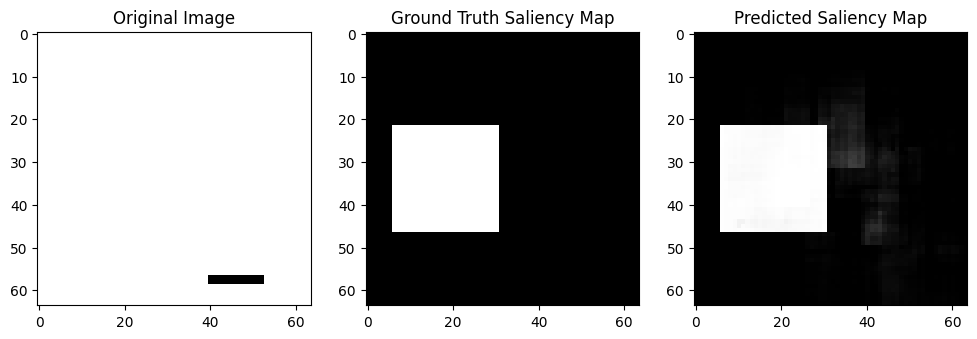

In [4]:
# Test the model
sample_index = 1  # Change this to test different samples
predicted_saliency_map = autoencoder.predict(images_gray[sample_index:sample_index + 1])[0]

# Plot original, ground truth, and predicted saliency maps
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(images_gray[sample_index, :, :, 0], cmap='gray')
plt.title('Original Image')
plt.subplot(1, 3, 2)
plt.imshow(saliency_maps[sample_index, :, :], cmap='gray')
plt.title('Ground Truth Saliency Map')
plt.subplot(1, 3, 3)
plt.imshow(predicted_saliency_map[:, :, 0], cmap='gray')
plt.title('Predicted Saliency Map')
plt.show()